In [200]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [201]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [202]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.5#0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 3000
Test set size: 3000


In [203]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])

In [204]:
from bin_and_delta import *

num_bins = 10
min_bin = 0
max_bin = 4

bin_idxs = np.zeros(len(t_x_data))
deltas = np.zeros(len(t_x_data))

for i in range(len(t_x_data)):
    bin_idxs[i], deltas[i] = get_bin_idx_and_delta(num_bins,min_bin,max_bin,t_x_data[i])

In [205]:
num_features = 1
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

In [206]:
dim1_data_scaled = bin_idxs

def prepare_data(dim1_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
    """
    Data preparation - mock of the real function (just for x here, no y and theta)
    
    For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
    [x1,y1,th1,x2,y2,th2]
    These are offset, so that x1 goes up until the second last frame
    (current frame is treated as future prediction)

    Output tensor holds single frame, for x, y, and theta values
    This is cropped to exclude the first n frames (n=2 here) and run up until the end
    So a synthesised 'future' value to aim for

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(dim1_data_scaled)

    x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_data)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
    y_data[:,0] = t_x[num_frames:]
    
    x_rows = x_data.size()[0]
    training_idx_limit = int(train_validate_ratio * x_rows)

    x_train = x_data[:training_idx_limit,:]
    x_valid = x_data[training_idx_limit:,:]

    y_train = y_data[:training_idx_limit,:]
    y_valid = y_data[training_idx_limit:,:]

    print('x_data dimensions:',x_data.size())
    print('x_train dimensions:',x_train.size())
    print('x_valid dimensions:',x_valid.size())
    print('y_data dimensions:',y_data.size())
    print('y_train dimensions:',y_train.size())
    print('y_valid dimensions:',y_valid.size())
    
    train_ds = TensorDataset(x_train,y_train)
    valid_ds = TensorDataset(x_valid,y_valid)
    
    return train_ds, valid_ds

# from dataset_prep import prepare_data
train_validate_ratio = 0.9
train_ds,valid_ds = \
prepare_data(dim1_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([2998, 2])
x_train dimensions: torch.Size([2698, 2])
x_valid dimensions: torch.Size([300, 2])
y_data dimensions: torch.Size([2998, 1])
y_train dimensions: torch.Size([2698, 1])
y_valid dimensions: torch.Size([300, 1])


In [207]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

epochs = 30
lr = 1e-2
batch_size = 30

model = Pose_Logistic()
loss_func = nn.MSELoss()

from network_helpers import *

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = Pose_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.12272897958755494
1 0.07445586659014225
2 0.060639073327183726
3 0.061974817886948586
4 0.05400167973712087
5 0.05295655499212444
6 0.052626771456561985
7 0.05401187392417341
8 0.058654208504594865
9 0.05399837482254952
10 0.05700707433279604
11 0.05356677293311805
12 0.05407734818290919
13 0.054736060765571894
14 0.05478040757589042
15 0.055687417672015724
16 0.05589864724315703
17 0.05956527520902455
18 0.05476404712535441
19 0.06138492242898792
20 0.055403039883822204
21 0.055513633391819896
22 0.05535277149174363
23 0.05789751675911248
24 0.05877630955073983
25 0.05784595063887536
26 0.05564337368123233
27 0.05773642496205866
28 0.057555643701925875
29 0.05634845192544162


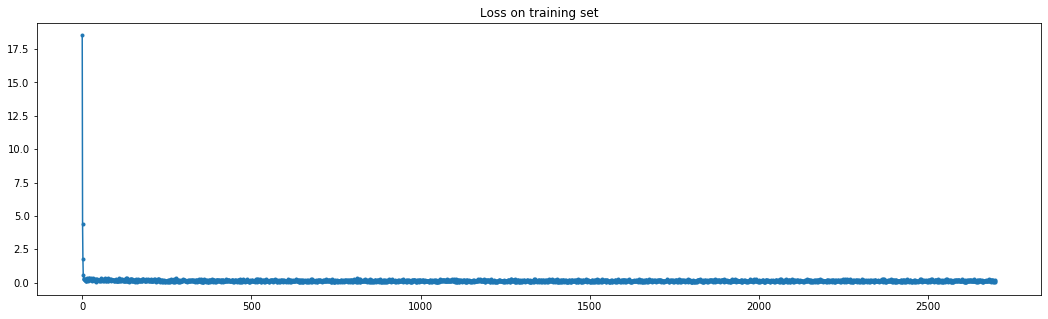

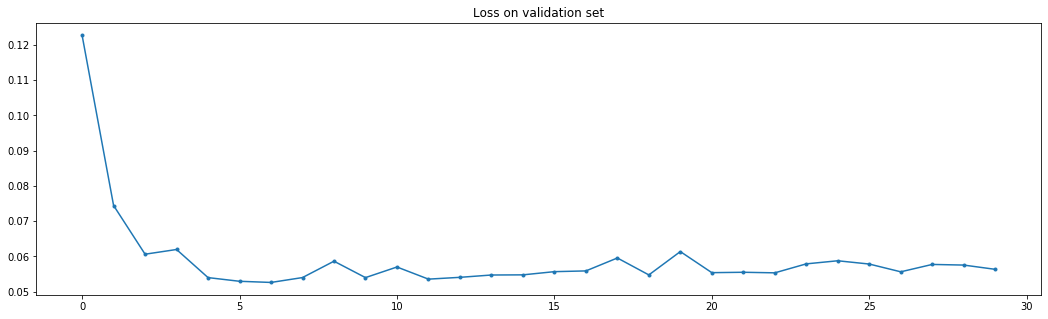

In [208]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

In [209]:
def query_at_index(model,dim1_data,num_frames,num_features,idx):
    """
    Query network at a particular input index.
    """
    import numpy as np
    import torch
    from torch.autograd import Variable 

    query_dim1 = []

    newest_frame_remaining = num_frames - 1
    for i in range(num_frames):
        query_dim1.append(dim1_data[idx+newest_frame_remaining])
        newest_frame_remaining -= 1

    scaled_query_dim1 = np.array(query_dim1) #(query_dim1 - dim1_data.mean())/dim1_data.std()

    # Build combination so x, y, and theta are adjacent for 1 pose
    c = np.empty(scaled_query_dim1.size)
    c[0::num_features] = scaled_query_dim1

    new_query = Variable(torch.Tensor([c]))

    answer = model(new_query)

    predicted_bin_idx_x = (answer[0][0]).data

    return predicted_bin_idx_x

idx = 170
predicted_bin_idx_x = query_at_index(model,dim1_data_scaled,num_frames,num_features,idx)

print(predicted_bin_idx_x)
print('True answer:',dim1_data[idx+num_frames])
print('...at frame',idx+num_frames)

tensor(1.0166)
True answer: 1.0
...at frame 172


Text(0.5, 1.0, 'Bin predictions for x pose on training data')

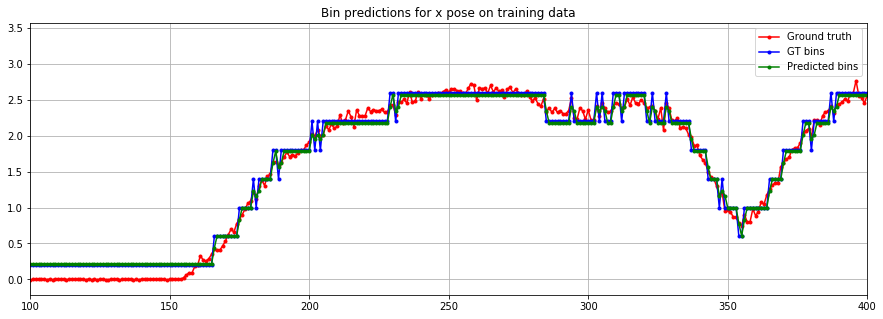

In [210]:
predicted_bin_idxs_x = np.zeros(len(dim1_data_scaled)-num_frames+1)
final_predictions_x = np.zeros(len(predicted_bin_idxs_x))
final_err_x = np.zeros(len(final_predictions_x))

for i in range(len(predicted_bin_idxs_x)): 
    predicted_bin_idxs_x[i] = query_at_index(model,dim1_data_scaled,num_frames,num_features,i)

    final_predictions_x[i] = predicted_bin_idxs_x[i] # TODO - add delta here

# If using previous 2 poses, there's one prediction. So predictions are num_frames - 1 shorter.
pred_offset = num_frames - 1

plot_idx_start = 100
plot_idx_end = 400

bin_range = (max_bin - min_bin)/num_bins

plt.figure(figsize=(15,5))
plt.plot(t_x_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(dim1_data_scaled[pred_offset:]*bin_range + bin_range/2,'b.-',label='GT bins')
plt.plot(final_predictions_x*bin_range + bin_range/2,'g.-',label='Predicted bins')
plt.legend()
plt.grid()
plt.xlim(plot_idx_start,plot_idx_end)
plt.title("Bin predictions for x pose on training data")

In [211]:
print(len(dim1_data_scaled))
print(len(predicted_bin_idxs_x))

3000
2999
